In [1]:
import os
import numpy as np
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt

In [2]:
img_rows, img_cols = 32 , 32


In [3]:
isolated_train_path= 'D:/CXR8/ChestX-ray'
isolated_test_path= 'D:/CXR8/ChestX-ray Test'

In [4]:
for root, dirnames, filenames in os.walk(isolated_train_path):
    for filename in filenames:
        file_path = os.path.join(root, filename)
        img = Image.open(file_path)
        Grey = img.resize((img_rows, img_cols))
        #img = ImageOps.invert(img)
        #Grey = img.convert('L')
        #ret,thresh1 = cv.threshold(Grey,127,255,cv.THRESH_BINARY)
        #threshold = 105
        #Grey = Grey.point(lambda p: p < threshold and 255)
        #Grey = ImageOps.invert(img)
        Grey = Grey.convert('RGB')
        Grey.save(file_path)

In [5]:
train_data_dir = isolated_train_path
validation_data_dir = isolated_test_path

In [6]:
img_width, img_height, channel = img_rows, img_cols, 3
batch_size = 20

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= True,
        class_mode ='categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        shuffle= False,
        class_mode ='categorical')

Found 10500 images belonging to 15 classes.
Found 1580 images belonging to 15 classes.


In [27]:
IMG_SHAPE = img_cols, img_rows, 3
classes = 15

In [28]:
num_epoch = 30
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 10500
num_validation_samples: 1580


In [29]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

In [30]:
def batch_normalization_relu_conv(x, filters, kernel_size):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
   
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    
    return x

In [31]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = batch_normalization_relu_conv(tensor, filters=4*k, kernel_size=1)
        x = batch_normalization_relu_conv(x, filters=k, kernel_size=3)
        #x =  tensorflow.keras.layers.Dropout(0.1)(x)
        tensor = Concatenate()([tensor, x])
    return tensor

In [32]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = batch_normalization_relu_conv(x, filters=f, kernel_size=1)
    #x =  tensorflow.keras.layers.Dropout(0.1)(x)
    #x = BatchNormalization()(x)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x

In [33]:
k = 12
theta = 0.5
repetitions = 10, 14, 16
input_layer = Input(IMG_SHAPE)

In [34]:
x = Conv2D(2*k, 7, strides=2, padding='same')(input_layer)
x = Dropout(0.1)(x)
x = MaxPool2D(3, strides=2, padding='same')(x)
#x = BatchNormalization()(x)

In [35]:
d = None
for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)
    #x = BatchNormalization()(x)
    
#x = BatchNormalization()(x)
x = GlobalAvgPool2D()(d)

output_layer = Dense(classes, activation='softmax')(x)

model = Model(input_layer, output_layer)

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 16, 16, 24)   3552        ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 16, 16, 24)   0           ['conv2d_84[0][0]']              
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 24)    0           ['dropout_1[0][0]']              
                                                                                            

In [37]:
opt = tensorflow.keras.optimizers.Adam()

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [40]:
history_1= model.fit(train_generator,
                    steps_per_epoch=num_train_samples // batch_size,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps=num_validation_samples // batch_size)

Epoch 1/100
525/525 [==============================] - 50s 96ms/step - loss: 2.3798 - accuracy: 0.2130 - val_loss: 2.7978 - val_accuracy: 0.1291
Epoch 2/100
525/525 [==============================] - 51s 98ms/step - loss: 2.3250 - accuracy: 0.2283 - val_loss: 2.7363 - val_accuracy: 0.1380
Epoch 3/100
525/525 [==============================] - 53s 101ms/step - loss: 2.2732 - accuracy: 0.2509 - val_loss: 2.7433 - val_accuracy: 0.1241
Epoch 4/100
525/525 [==============================] - 52s 99ms/step - loss: 2.2299 - accuracy: 0.2597 - val_loss: 2.6779 - val_accuracy: 0.1424
Epoch 5/100
525/525 [==============================] - 52s 100ms/step - loss: 2.1938 - accuracy: 0.2749 - val_loss: 2.7064 - val_accuracy: 0.1772
Epoch 6/100
525/525 [==============================] - 52s 99ms/step - loss: 2.1521 - accuracy: 0.2920 - val_loss: 2.6931 - val_accuracy: 0.1728
Epoch 7/100
525/525 [==============================] - 52s 99ms/step - loss: 2.1002 - accuracy: 0.3006 - val_loss: 3.0732 - val_

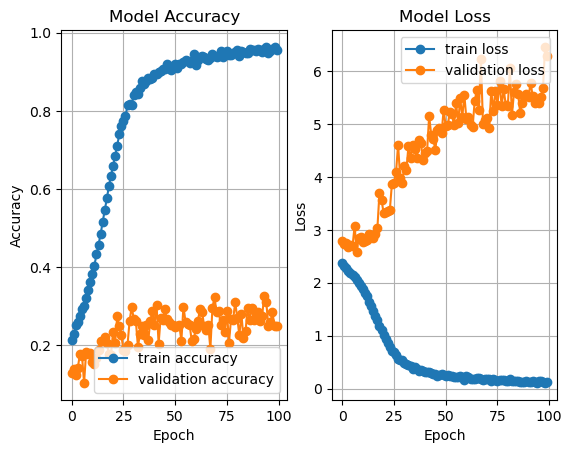

In [43]:
# Plot training & validation accuracy values
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history_1.history['val_accuracy'], 'o-', label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], 'o-', label='train loss')
plt.plot(history_1.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [41]:
import seaborn as sns


ModuleNotFoundError: No module named 'seaborn'

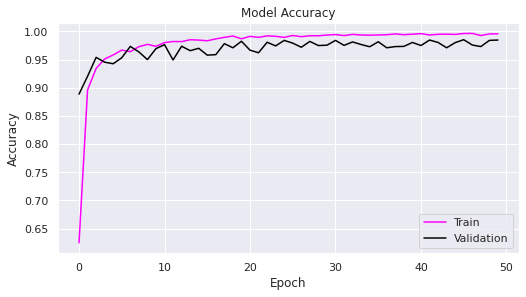

In [ ]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['accuracy'], color="Magenta")
plt.plot(history_1.history['val_accuracy'] , color="Black")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('/home/nazia/Desktop/Research/Compound/Graph/CompoundDenseAdamAccuracy.svg')



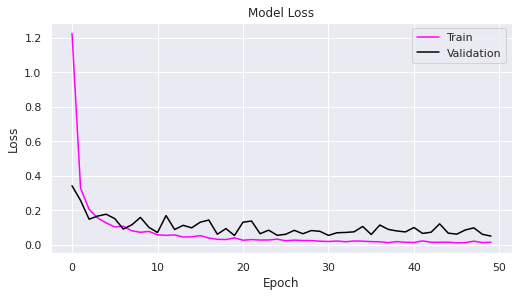

In [ ]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['loss'], color="magenta")
plt.plot(history_1.history['val_loss'], color="Black")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('/home/nazia/Desktop/Research/Compound/Graph/CompoundDenseAdamLoss.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/Com_loss18.png')

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = model.predict_generator(validation_generator, num_validation_samples// batch_size)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81','82','83','84']
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

/tmp/ipykernel_17720/974193040.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_validation_samples// batch_size)


(3280, 24)
              precision    recall  f1-score   support

          61      1.000     0.885     0.939       148
          62      1.000     0.993     0.997       150
          63      1.000     1.000     1.000       135
          64      0.925     1.000     0.961       136
          65      1.000     0.922     0.960       129
          66      1.000     1.000     1.000       149
          67      1.000     1.000     1.000       135
          68      0.993     0.993     0.993       149
          69      1.000     0.968     0.984       124
          70      1.000     0.985     0.992       133
          71      0.985     0.962     0.973       133
          72      0.901     1.000     0.948       127
          73      0.993     1.000     0.997       151
          74      1.000     1.000     1.000       129
          75      0.993     0.993     0.993       141
          76      1.000     1.000     1.000       116
          77      1.000     1.000     1.000       140
          78    

In [ ]:
cm = confusion_matrix(y_true, y_pred)

In [ ]:
classes=24

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.BuGn
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

In [ ]:
import imp
imp.reload(sns)

<module 'seaborn' from '/home/nazia/.local/lib/python3.10/site-packages/seaborn/__init__.py'>

In [ ]:
sns.reset_defaults()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# plt.figure() 
# prop = FontProperties()
# prop.set_file('Siyamrupali.ttf')

Confusion matrix, without normalization
[[131   0   0   1   0   0   0   0   0   0   0  14   0   0   0   0   0   0
    0   0   0   0   1   1]
 [  0 149   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0]
 [  0   0 135   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 136   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0  10 119   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 149   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 135   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 148   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   1]
 [  0   0   0   0   0   0   0   1 120   0   0   0   0   0   0   0   0   0
    2   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0 131   0   0  

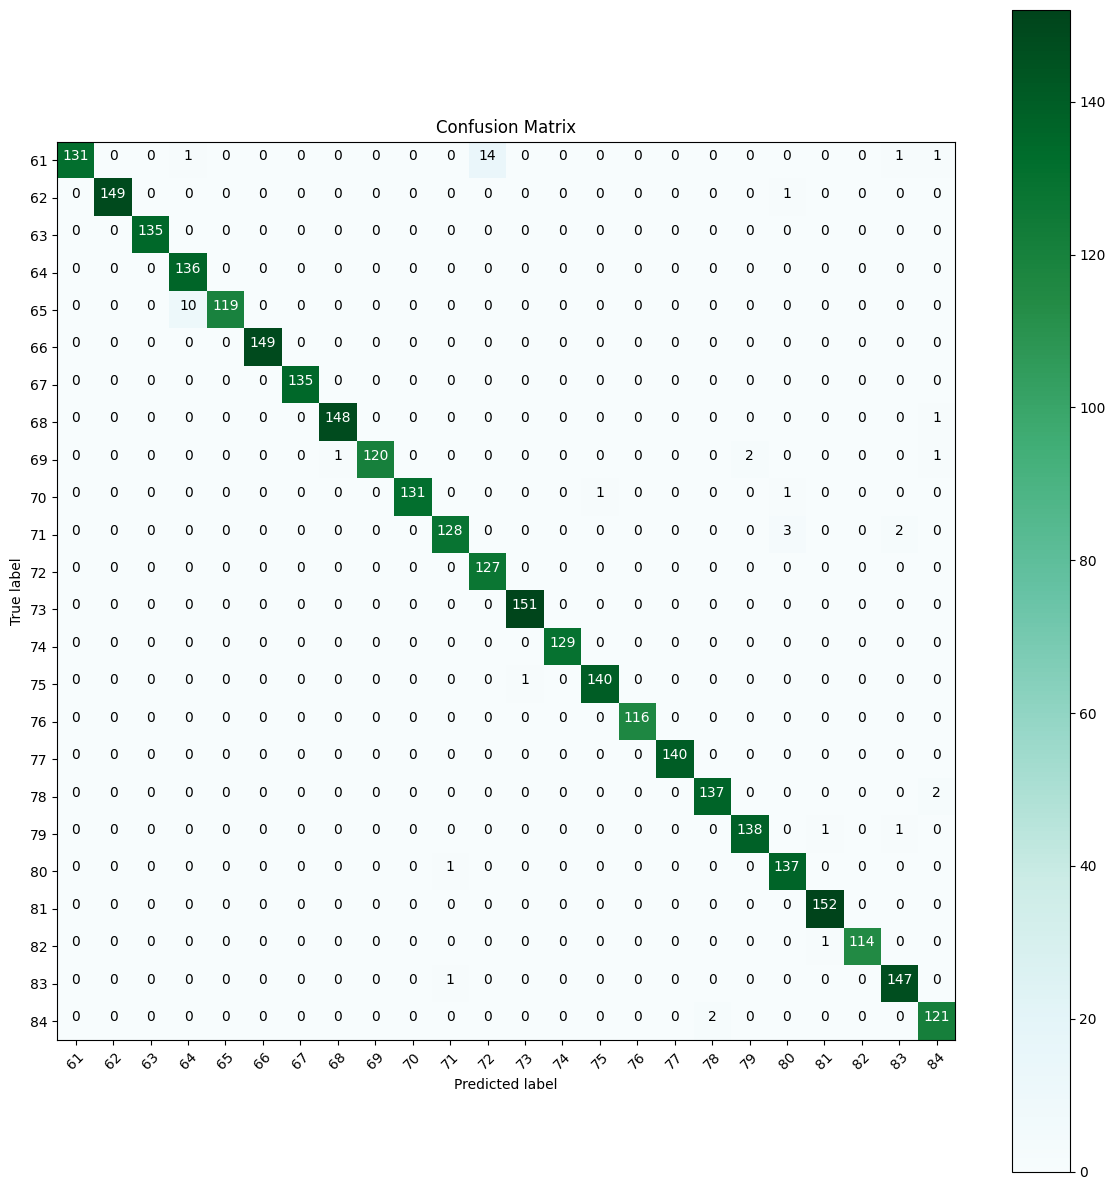

In [ ]:
cm_plot_labels = ['61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81','82','83','84']
#sns.set_theme()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig('/home/nazia/Desktop/Research/Compound/Graph/CompoundAdamDenseNetCF.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/cf_val_git_05.png')